<a href="https://colab.research.google.com/github/divsspace/SOCIAL-MEDIA-FAKE-NEWS-DETECTION-MODEL/blob/main/FAKE_NEWS_MODEL_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


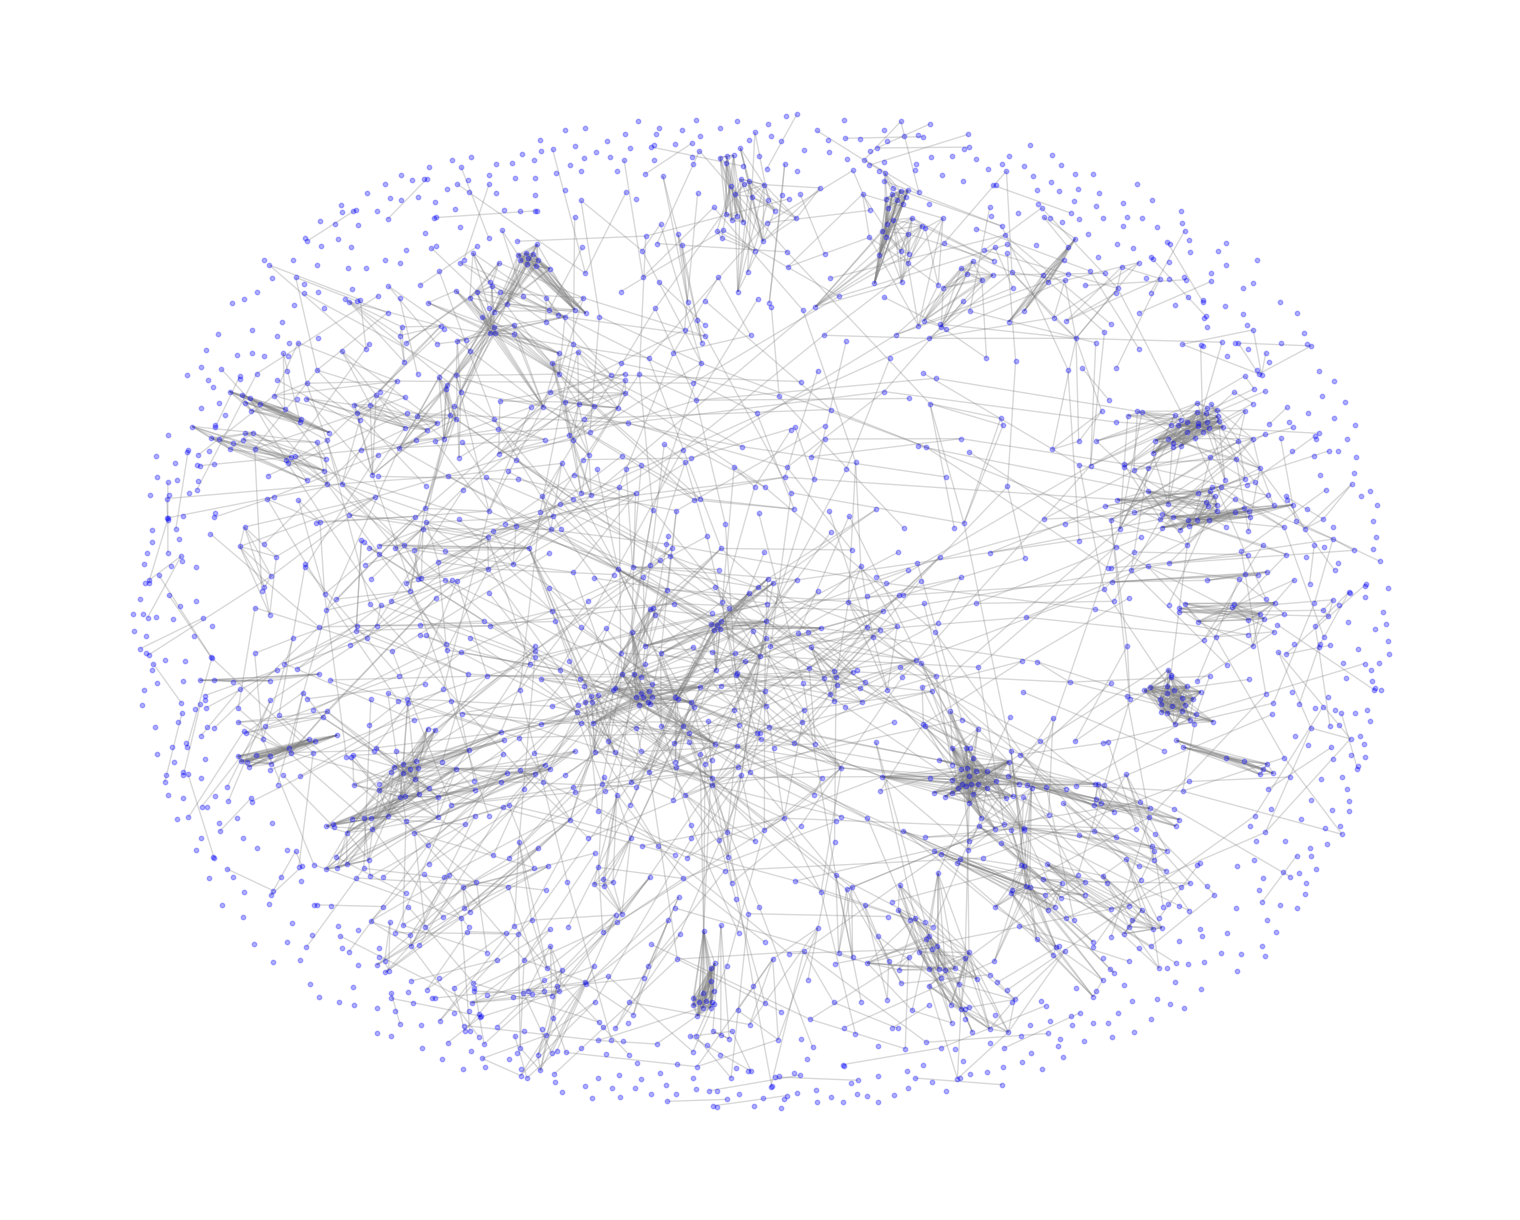

Full graph visualization complete.


In [ ]:
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from google.colab import drive

drive.mount('/content/drive')

dataset_path_15 = "/content/drive/MyDrive/archive2/twitter15"
dataset_path_16 = "/content/drive/MyDrive/archive2/twitter16"

label_mapping = {"true": 0, "false": 1, "unverified": 2, "non-rumor": 3}

#cleaning tweets, will be saved for future use
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  #remove urls
    text = re.sub(r"@\w+", "", text)  #remove mentions
    text = re.sub(r"#\w+", "", text)  #remove hashtags
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  #remove special characters
    return text.strip()

def load_data(dataset_path): #dataset loading
    label_path = os.path.join(dataset_path, "label.txt")
    tweets_path = os.path.join(dataset_path, "source_tweets.txt")

    labels = {}
    tweets = {}

    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            label, tweet_id = line.strip().split(":")
            if label in label_mapping:
                labels[tweet_id] = label_mapping[label]

    with open(tweets_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t", 1)
            if len(parts) == 2:
                tweet_id, text = parts
                cleaned_text = clean_text(text)
                if tweet_id in labels and cleaned_text:
                    tweets[tweet_id] = cleaned_text

    return tweets, labels

tweets_15, labels_15 = load_data(dataset_path_15)
tweets_16, labels_16 = load_data(dataset_path_16)

tweets = {**tweets_15, **tweets_16}
labels = {**labels_15, **labels_16}

#feature engineering
vectorizer = TfidfVectorizer(max_features=500)
tweet_features = vectorizer.fit_transform(tweets.values()).toarray()

sentiment_scores = {tweet_id: TextBlob(text).sentiment.polarity for tweet_id, text in tweets.items()}

G = nx.Graph()

for i, (tweet_id, text) in enumerate(tweets.items()):
    G.add_node(tweet_id, node_type="Tweet", label=labels[tweet_id], text=text, features=tweet_features[i], sentiment=sentiment_scores[tweet_id])

similarity_matrix = cosine_similarity(tweet_features)
threshold = 0.5  #similarity threshold to create an edge, according to similar words found in tweets

for i, id1 in enumerate(tweets.keys()):
    for j, id2 in enumerate(tweets.keys()):
        if i != j and similarity_matrix[i, j] > threshold:
            G.add_edge(id1, id2, weight=similarity_matrix[i, j], relation="text_similarity")

def check_nodes_integrity():
    dataset_nodes = set(tweets.keys())
    graph_nodes = set(G.nodes)
    return dataset_nodes == graph_nodes

plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, seed=42, k=0.1)
nx.draw(G, pos, with_labels=False, node_size=10, node_color="blue", edge_color="gray", alpha=0.3)
plt.show()

print("Full graph visualization complete.")

In [ ]:
#graph validation/correctness based on similar word interaction

def check_graph_correctness():
    dataset_nodes = set(tweets.keys())
    graph_nodes = set(G.nodes)
    missing_nodes = dataset_nodes - graph_nodes
    extra_nodes = graph_nodes - dataset_nodes

    #edges have valid nodes or not
    invalid_edges = [(u, v) for u, v in G.edges if u not in graph_nodes or v not in graph_nodes]

    print(f"Total nodes in dataset: {len(dataset_nodes)}")
    print(f"Total nodes in graph: {len(graph_nodes)}")
    print(f"Missing nodes in graph: {len(missing_nodes)}")
    print(f"Extra nodes in graph: {len(extra_nodes)}")
    print(f"Total edges in graph: {len(G.edges)}")
    print(f"Invalid edges (edges with missing nodes): {len(invalid_edges)}")

    if len(missing_nodes) == 0 and len(extra_nodes) == 0 and len(invalid_edges) == 0:
        print("The graph is correctly built")
    else:
        print("Issues detected in the graph structure")

check_graph_correctness()
check_graph_correctness()

Total nodes in dataset: 2138
Total nodes in graph: 2138
Missing nodes in graph: 0
Extra nodes in graph: 0
Total edges in graph: 3767
Invalid edges (edges with missing nodes): 0
The graph is correctly built
Total nodes in dataset: 2138
Total nodes in graph: 2138
Missing nodes in graph: 0
Extra nodes in graph: 0
Total edges in graph: 3767
Invalid edges (edges with missing nodes): 0
The graph is correctly built


In [ ]:
#preprocessed data saved for further use

import pickle

save_path = "/content/drive/MyDrive/archive2/preprocessed_data.pkl"

preprocessed_data = {
    "tweets": tweets,
    "labels": labels,
    "features": tweet_features,
    "sentiment_scores": sentiment_scores
}

with open(save_path, "wb") as f:
    pickle.dump(preprocessed_data, f)

print(f"Preprocessed data saved successfully at {save_path}")

Preprocessed data saved successfully at /content/drive/MyDrive/archive2/preprocessed_data.pkl


In [ ]:
#preprocessed data to verify cleaning of tweets
#special characters, emojis, other unwanted things removed

import pickle

save_path = "/content/drive/MyDrive/archive2/preprocessed_data.pkl"
with open(save_path, "rb") as f:
    preprocessed_data = pickle.load(f)

tweets = preprocessed_data["tweets"]
labels = preprocessed_data["labels"] #true, false, etc.
sentiments = preprocessed_data["sentiment_scores"]

for i, tweet_id in enumerate(list(tweets.keys())[:5]):
    print(f"Tweet ID: {tweet_id}")
    print(f"Cleaned Text: {tweets[tweet_id]}")
    print(f"Label: {labels[tweet_id]}")
    print("-" * 50)


Tweet ID: 731166399389962242
Cleaned Text: ca kkk grand wizard  endorses    url
Label: 2
--------------------------------------------------
Tweet ID: 714598641827246081
Cleaned Text: an open letter to trump voters from his top strategistturneddefector url via
Label: 2
--------------------------------------------------
Tweet ID: 691809004356501505
Cleaned Text: america is a nation of second chances  on new reforms to solitary confinement url url
Label: 3
--------------------------------------------------
Tweet ID: 693204708933160960
Cleaned Text: brandon marshall visits and offers advice support to brother of fallen hero zaevion dobson url url
Label: 3
--------------------------------------------------
Tweet ID: 551099691702956032
Cleaned Text: rip elly may clampett so sad to learn  star donna douglas has passed away url
Label: 0
--------------------------------------------------


In [ ]:
#raw data for comparison
def load_raw_tweets(dataset_path):
    tweets_path = os.path.join(dataset_path, "source_tweets.txt")
    raw_tweets = {}

    with open(tweets_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t", 1)
            if len(parts) == 2:
                tweet_id, text = parts
                raw_tweets[tweet_id] = text

    return raw_tweets

raw_tweets_15 = load_raw_tweets(dataset_path_15)
raw_tweets_16 = load_raw_tweets(dataset_path_16)

raw_tweets = {**raw_tweets_15, **raw_tweets_16}

for i, (tweet_id, text) in enumerate(list(raw_tweets.items())[:5]):
    print(f"Tweet ID: {tweet_id}")
    print(f"Raw Text: {text}")
    print("-" * 50)


Tweet ID: 731166399389962242
Raw Text: 🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL
--------------------------------------------------
Tweet ID: 714598641827246081
Raw Text: an open letter to trump voters from his top strategist-turned-defector URL via @xojanedotcom
--------------------------------------------------
Tweet ID: 691809004356501505
Raw Text: "america is a nation of second chances" —@potus on new reforms to solitary confinement: URL URL
--------------------------------------------------
Tweet ID: 693204708933160960
Raw Text: brandon marshall visits and offers advice, support to brother of fallen hero zaevion dobson: URL URL
--------------------------------------------------
Tweet ID: 551099691702956032
Raw Text: rip elly may clampett: so sad to learn #beverlyhillbillies star donna douglas has passed away. URL
--------------------------------------------------


In [ ]:
#data consistency, checking for missing labels and removing them
#no data loss
#earlier 2139, 1 label missing, after check: 2138

# Define tweet_ids, tweet_texts, tweet_labels before using them
tweet_ids = list(tweets.keys())
tweet_texts = list(tweets.values())
tweet_labels = list(labels.values())

print(f"Tweet IDs: {len(tweet_ids)}")
print(f"Tweet Texts: {len(tweet_texts)}")
print(f"Tweet Labels: {len(tweet_labels)}")
print(f"Tweet Features: {len(tweet_features)}")

id_set = set(tweet_ids)
label_set = set(labels.keys())

extra_labels = label_set - id_set
missing_labels = id_set - label_set

print(f"Extra labels (not in tweet IDs): {extra_labels}")
print(f"Missing labels (not in labels dict): {missing_labels}")

if extra_labels:
    for extra_id in extra_labels:
        del labels[extra_id]

tweet_labels = list(labels.values())

print(f"After Fixing - Tweet Labels: {len(tweet_labels)}")

Tweet IDs: 2138
Tweet Texts: 2138
Tweet Labels: 2139
Tweet Features: 2138
Extra labels (not in tweet IDs): {'568452856224747520'}
Missing labels (not in labels dict): set()
After Fixing - Tweet Labels: 2138


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

tweet_ids = list(tweets.keys())
tweet_texts = list(tweets.values())
tweet_labels = list(labels.values())
tweet_features = np.array(tweet_features)

#split into 70% training, 30% to further split
train_ids, remaining_ids, train_texts, remaining_texts, train_labels, remaining_labels, train_features, remaining_features = train_test_split(
    tweet_ids, tweet_texts, tweet_labels, tweet_features, test_size=0.3, random_state=42, stratify=tweet_labels
)

#15% for testing, 15% for validation
val_ids, test_ids, val_texts, test_texts, val_labels, test_labels, val_features, test_features = train_test_split(
    remaining_ids, remaining_texts, remaining_labels, remaining_features, test_size=0.5, random_state=42, stratify=remaining_labels
)

print(f"Training Data: {len(train_ids)} tweets") #1496
print(f"Validation Data: {len(val_ids)} tweets") #321
print(f"Testing Data: {len(test_ids)} tweets") #321

#total = 2138

split_data = {
    "train": {"ids": train_ids, "texts": train_texts, "labels": train_labels, "features": train_features},
    "val": {"ids": val_ids, "texts": val_texts, "labels": val_labels, "features": val_features},
    "test": {"ids": test_ids, "texts": test_texts, "labels": test_labels, "features": test_features},
}


Training Data: 1496 tweets
Validation Data: 321 tweets
Testing Data: 321 tweets


In [ ]:
#saving split data
import pickle

save_path = "/content/drive/MyDrive/archive2/split_preprocessed_data.pkl"

with open(save_path, "wb") as f:
    pickle.dump(split_data, f)

print(f"Split saved at {save_path}")

Split saved at /content/drive/MyDrive/archive2/split_preprocessed_data.pkl


In [ ]:
import pickle

from google.colab import drive
drive.mount('/content/drive')

split_data_path = "/content/drive/MyDrive/archive2/split_preprocessed_data.pkl"
with open(split_data_path, "rb") as f:
    split_data = pickle.load(f)

print("Split dataset loaded successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Split dataset loaded successfully!


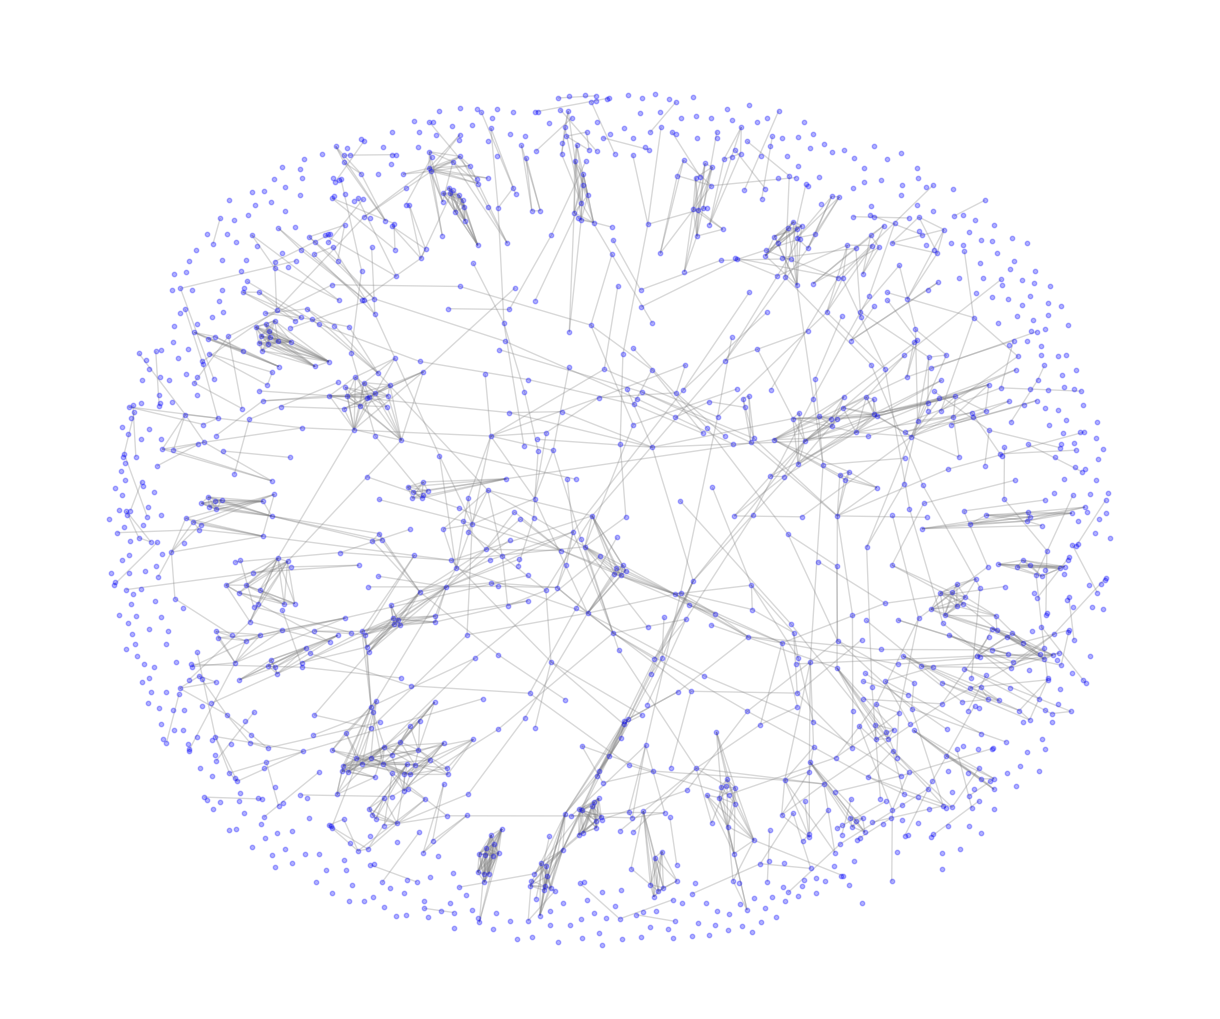

Training graph visualization complete!


In [ ]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

G_train = nx.Graph()

train_ids = split_data["train"]["ids"]
train_texts = split_data["train"]["texts"]
train_labels = split_data["train"]["labels"]
train_features = split_data["train"]["features"]

for i, tweet_id in enumerate(train_ids):
    G_train.add_node(tweet_id, node_type="Tweet", label=train_labels[i], text=train_texts[i], features=train_features[i])

similarity_matrix = cosine_similarity(train_features)
threshold = 0.5

for i, id1 in enumerate(train_ids):
    for j, id2 in enumerate(train_ids):
        if i != j and similarity_matrix[i, j] > threshold:
            G_train.add_edge(id1, id2, weight=similarity_matrix[i, j], relation="text_similarity")

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_train, seed=42, k=0.1)
nx.draw(G_train, pos, with_labels=False, node_size=10, node_color="blue", edge_color="gray", alpha=0.3)
plt.show()

print("Training graph visualization complete!")

In [ ]:
!pip install torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

def convert_to_pyg(graph):
    pyg_graph = from_networkx(graph)
    return pyg_graph

pyg_train = convert_to_pyg(G_train)

# Create and convert validation and test graphs similar to the training graph

# --- Create G_val ---
val_ids = split_data["val"]["ids"]
val_texts = split_data["val"]["texts"]
val_labels = split_data["val"]["labels"]
val_features = split_data["val"]["features"]

G_val = nx.Graph()  # Initialize the validation graph
for i, tweet_id in enumerate(val_ids):
    G_val.add_node(tweet_id, node_type="Tweet", label=val_labels[i], text=val_texts[i], features=val_features[i])

similarity_matrix_val = cosine_similarity(val_features)
threshold = 0.5
for i, id1 in enumerate(val_ids):
    for j, id2 in enumerate(val_ids):
        if i != j and similarity_matrix_val[i, j] > threshold:
            G_val.add_edge(id1, id2, weight=similarity_matrix_val[i, j], relation="text_similarity")
# --- End of Create G_val ---

pyg_val = convert_to_pyg(G_val)

# --- Create G_test ---
test_ids = split_data["test"]["ids"]
test_texts = split_data["test"]["texts"]
test_labels = split_data["test"]["labels"]
test_features = split_data["test"]["features"]

G_test = nx.Graph()  # Initialize the test graph
for i, tweet_id in enumerate(test_ids):
    G_test.add_node(tweet_id, node_type="Tweet", label=test_labels[i], text=test_texts[i], features=test_features[i])

similarity_matrix_test = cosine_similarity(test_features)
threshold = 0.5
for i, id1 in enumerate(test_ids):
    for j, id2 in enumerate(test_ids):
        if i != j and similarity_matrix_test[i, j] > threshold:
            G_test.add_edge(id1, id2, weight=similarity_matrix_test[i, j], relation="text_similarity")
# --- End of Create G_test ---

pyg_test = convert_to_pyg(G_test)


print("Graphs successfully converted for PyTorch Geometric!")

Graphs successfully converted for PyTorch Geometric!


In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

def convert_to_pyg_with_features(G, is_undirected=True):
    # Get node features and labels from the NetworkX graph
    node_features = []
    node_labels = []

    # Ensure consistent node ordering
    nodes = list(G.nodes())

    for node in nodes:
        node_features.append(G.nodes[node]['features'])
        node_labels.append(G.nodes[node]['label'])

    # Convert to torch tensors
    x = torch.FloatTensor(node_features)
    y = torch.LongTensor(node_labels)

    # Convert the NetworkX graph to PyG format
    pyg_graph = from_networkx(G)

    # Add the features and labels
    pyg_graph.x = x
    pyg_graph.y = y

    if is_undirected:
        pyg_graph.edge_index = torch.cat([pyg_graph.edge_index,
                                        pyg_graph.edge_index.flip(0)], dim=1)

    return pyg_graph

# Convert all three graphs
pyg_train = convert_to_pyg_with_features(G_train)
pyg_val = convert_to_pyg_with_features(G_val)
pyg_test = convert_to_pyg_with_features(G_test)

# Verify the conversion
print("Training Graph:")
print(f"Number of nodes: {pyg_train.num_nodes}")
print(f"Number of edges: {pyg_train.num_edges}")
print(f"Feature dimensions: {pyg_train.x.size()}")
print(f"Number of labels: {pyg_train.y.size(0)}")

# Now we can proceed with the model implementation
in_channels = pyg_train.x.size(1)  # Feature dimension from your TF-IDF
hidden_channels = 64
out_channels = 4  # Number of classes (true, false, unverified, non-rumor)
num_relations = 1  # Currently only using text_similarity relation

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RGCN(in_channels, hidden_channels, out_channels, num_relations).to(device)

print("\nModel created successfully!")

Training Graph:
Number of nodes: 1496
Number of edges: 7520
Feature dimensions: torch.Size([1496, 500])
Number of labels: 1496

Model created successfully!


In [ ]:
# Debug checks
print("Available keys in split_data:", split_data.keys())
print("\nAvailable keys in split_data['train']:", split_data['train'].keys())
print("\nSample of data shapes:")
for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()} split:")
    for key, value in split_data[split].items():
        if isinstance(value, (list, np.ndarray)):
            print(f"{key}: {len(value)} items")

Available keys in split_data: dict_keys(['train', 'val', 'test'])

Available keys in split_data['train']: dict_keys(['ids', 'texts', 'labels', 'features'])

Sample of data shapes:

TRAIN split:
ids: 1496 items
texts: 1496 items
labels: 1496 items
features: 1496 items

VAL split:
ids: 321 items
texts: 321 items
labels: 321 items
features: 321 items

TEST split:
ids: 321 items
texts: 321 items
labels: 321 items
features: 321 items


Starting execution at 2025-02-10 12:44:50

Starting enhanced training...

Enhancing features...

Starting training...
Epoch 000: Train Loss: 1.5341, Val Loss: 1.4553, Train Acc: 0.2326, Val Acc: 0.2679
Epoch 001: Train Loss: 1.5280, Val Loss: 1.3807, Train Acc: 0.2767, Val Acc: 0.2586
Epoch 002: Train Loss: 1.4339, Val Loss: 1.3704, Train Acc: 0.2821, Val Acc: 0.2991
Epoch 003: Train Loss: 1.3984, Val Loss: 1.3789, Train Acc: 0.2848, Val Acc: 0.2804
Epoch 004: Train Loss: 1.3940, Val Loss: 1.3715, Train Acc: 0.2767, Val Acc: 0.3146
Epoch 005: Train Loss: 1.3887, Val Loss: 1.3671, Train Acc: 0.2894, Val Acc: 0.2991
Epoch 006: Train Loss: 1.3815, Val Loss: 1.3667, Train Acc: 0.2975, Val Acc: 0.2991
Epoch 007: Train Loss: 1.3833, Val Loss: 1.3661, Train Acc: 0.2968, Val Acc: 0.2991
Epoch 008: Train Loss: 1.3714, Val Loss: 1.3670, Train Acc: 0.3048, Val Acc: 0.2991
Epoch 009: Train Loss: 1.3769, Val Loss: 1.3688, Train Acc: 0.3168, Val Acc: 0.2991
Epoch 010: Train Loss: 1.3735, Val Loss: 1

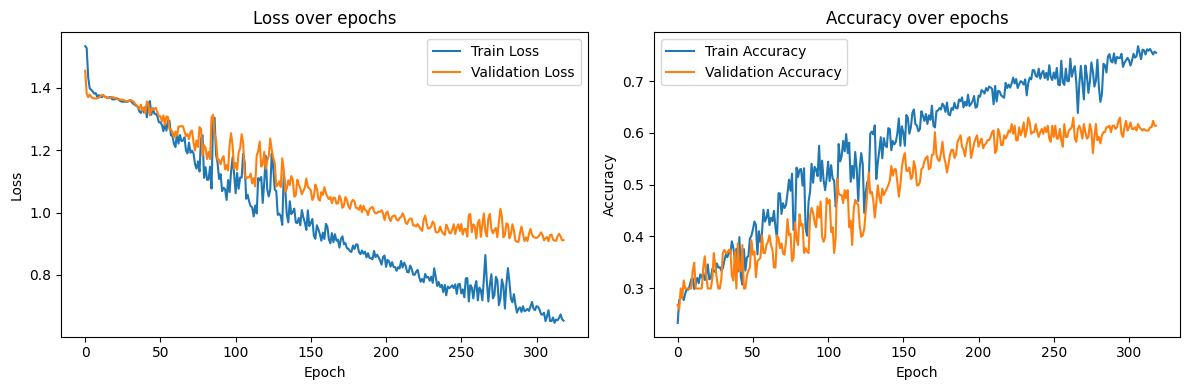


Results saved as rgcn_results_2025-02-10_12-44-50.pt

Generating Performance Visualizations...


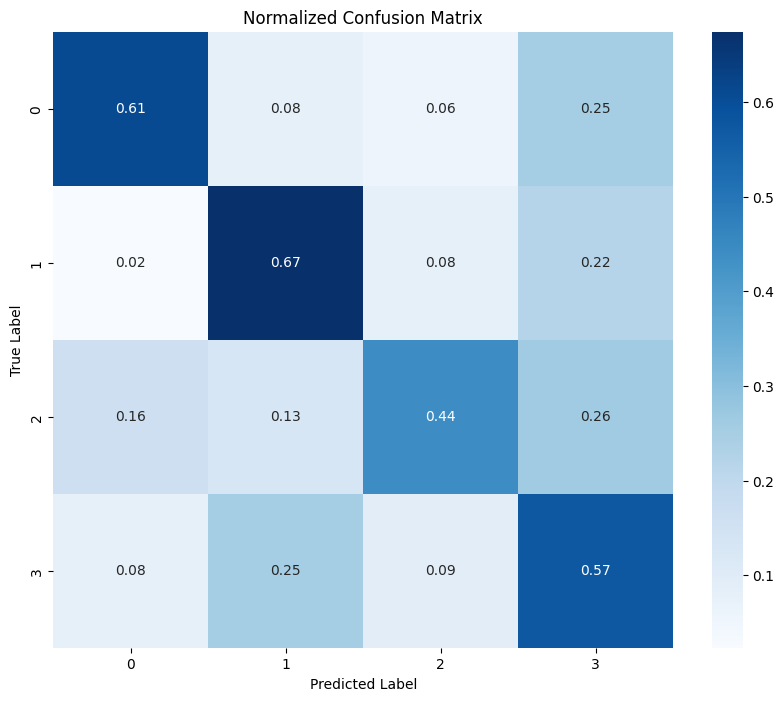

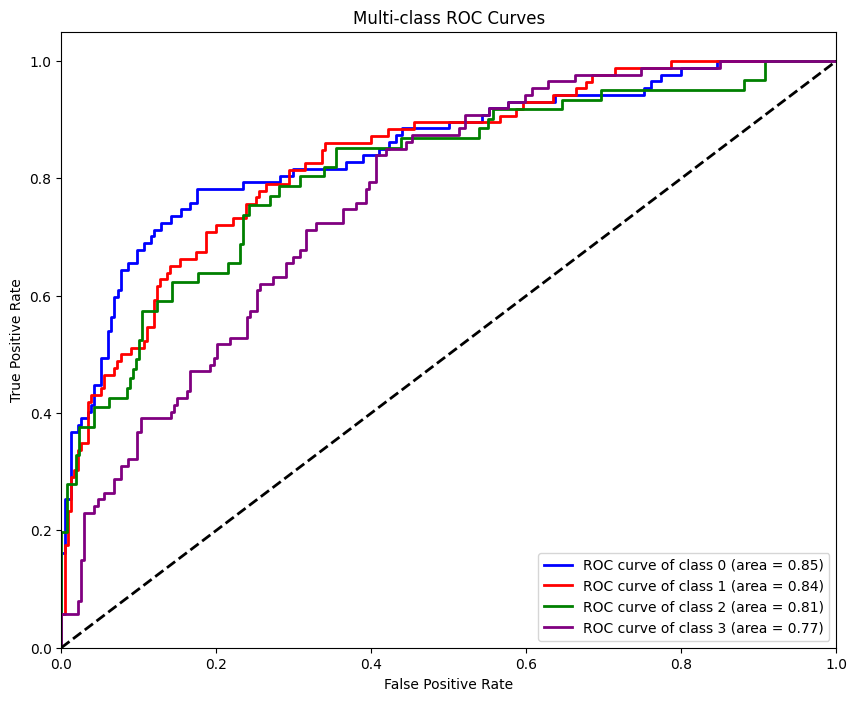

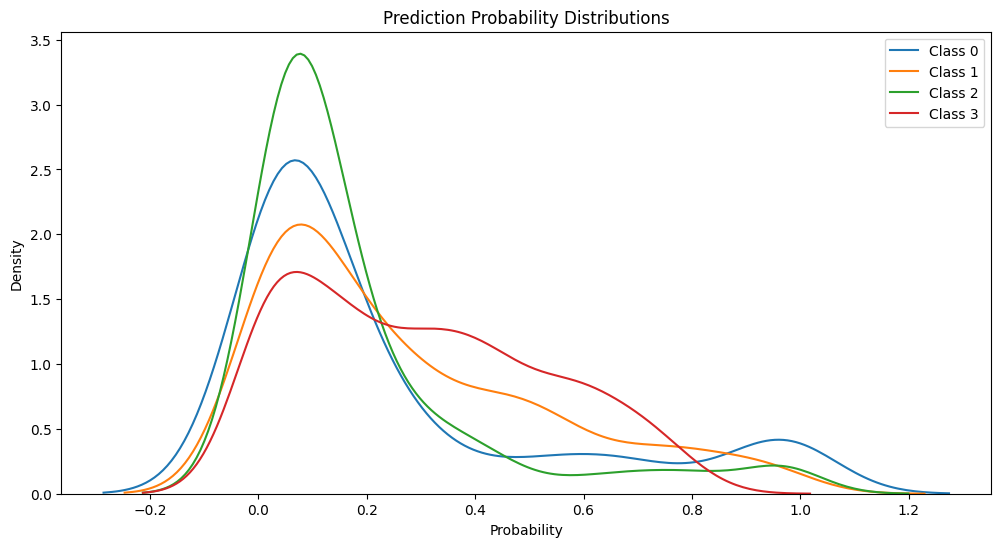


Class-wise Performance Metrics:
         Precision    Recall  F1-score
Class 0   0.736111  0.609195  0.666667
Class 1   0.610526  0.674419  0.640884
Class 2   0.574468  0.442623  0.500000
Class 3   0.467290  0.574713  0.515464


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from textblob import TextBlob
import sklearn.metrics as metrics
from itertools import cycle
import pandas as pd

# Constants
TIMESTAMP = "2025-02-10 12:44:50"

# 1. Stabilized RGCN Model
class EnhancedRGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations, num_bases=16):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations, num_bases=num_bases)
        self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations, num_bases=num_bases)
        self.skip = torch.nn.Linear(in_channels, hidden_channels)
        self.linear1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.linear2 = torch.nn.Linear(hidden_channels, out_channels)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels)
        self.dropout = torch.nn.Dropout(p=0.25)

    def forward(self, x, edge_index, edge_type):
        identity = self.skip(x)
        x = self.conv1(x, edge_index, edge_type)
        x = self.norm1(x)
        x = F.relu(x)
        x = x + identity
        x = self.dropout(x)

        identity = x
        x = self.conv2(x, edge_index, edge_type)
        x = self.norm2(x)
        x = F.relu(x)
        x = x + identity
        x = self.dropout(x)

        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)

        return F.log_softmax(x, dim=1)

# 2. Configuration
class Config:
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-5
    HIDDEN_CHANNELS = 96
    EPOCHS = 400
    EARLY_STOPPING_PATIENCE = 30
    DROPOUT = 0.25
    NUM_BASES = 16
    GRADIENT_CLIP = 0.5
    BATCH_SIZE = 32

# 3. Feature Engineering
def enhance_features(features, texts):
    enhanced_features = []

    for idx, (feat, text) in enumerate(zip(features, texts)):
        original_feat = np.array(feat)
        text = text.lower()
        words = text.split()
        word_count = len(words)
        char_count = len(text)
        unique_words = len(set(words))

        word_density = unique_words / word_count if word_count > 0 else 0
        avg_word_length = char_count / word_count if word_count > 0 else 0

        blob = TextBlob(text)
        sentiment = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity

        additional_features = [
            word_count / 1000,
            char_count / 5000,
            unique_words / 100,
            word_density,
            avg_word_length / 10,
            sentiment,
            subjectivity,
            sentiment * subjectivity,
            word_density * avg_word_length
        ]

        combined_features = np.concatenate([original_feat, additional_features])
        enhanced_features.append(combined_features)

    scaler = StandardScaler()
    enhanced_features = scaler.fit_transform(enhanced_features)

    minmax = MinMaxScaler(feature_range=(-1, 1))
    enhanced_features = minmax.fit_transform(enhanced_features)

    return torch.FloatTensor(enhanced_features)

# 4. Training History Class
class TrainingHistory:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def plot_metrics(self):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Loss over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accs, label='Train Accuracy')
        plt.plot(self.val_accs, label='Validation Accuracy')
        plt.title('Accuracy over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

# 5. Training Function
def train_and_evaluate_enhanced():
    history = TrainingHistory()
    optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.EPOCHS, eta_min=Config.LEARNING_RATE * 0.1)

    print("\nEnhancing features...")
    enhanced_x_train = enhance_features(split_data['train']['features'], split_data['train']['texts']).to(device)
    enhanced_x_val = enhance_features(split_data['val']['features'], split_data['val']['texts']).to(device)

    edge_index_train = pyg_train.edge_index.to(device)
    edge_type_train = torch.zeros(pyg_train.edge_index.size(1), dtype=torch.long).to(device)
    labels_train = torch.LongTensor(split_data['train']['labels']).to(device)

    edge_index_val = pyg_val.edge_index.to(device)
    edge_type_val = torch.zeros(pyg_val.edge_index.size(1), dtype=torch.long).to(device)
    labels_val = torch.LongTensor(split_data['val']['labels']).to(device)

    best_val_loss = float('inf')
    counter = 0
    best_epoch = 0

    print("\nStarting training...")
    for epoch in range(Config.EPOCHS):
        model.train()
        optimizer.zero_grad()

        out_train = model(enhanced_x_train, edge_index_train, edge_type_train)
        loss_train = F.nll_loss(out_train, labels_train)
        acc_train = (out_train.argmax(dim=1) == labels_train).float().mean()

        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=Config.GRADIENT_CLIP)
        optimizer.step()
        scheduler.step()

        model.eval()
        with torch.no_grad():
            out_val = model(enhanced_x_val, edge_index_val, edge_type_val)
            loss_val = F.nll_loss(out_val, labels_val)
            acc_val = (out_val.argmax(dim=1) == labels_val).float().mean()

        history.train_losses.append(loss_train.item())
        history.val_losses.append(loss_val.item())
        history.train_accs.append(acc_train.item())
        history.val_accs.append(acc_val.item())

        print(f'Epoch {epoch:03d}: Train Loss: {loss_train:.4f}, Val Loss: {loss_val:.4f}, '
              f'Train Acc: {acc_train:.4f}, Val Acc: {acc_val:.4f}')

        if loss_val < best_val_loss:
            best_val_loss = loss_val
            counter = 0
            best_epoch = epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_val,
                'acc': acc_val,
            }, 'best_model.pt')
        else:
            counter += 1
            if counter >= Config.EARLY_STOPPING_PATIENCE:
                print(f'\nEarly stopping at epoch {epoch}')
                break

    print(f'\nTraining finished! Best model saved at epoch {best_epoch}')
    return history, enhanced_x_val, edge_index_val, edge_type_val, labels_val

# 6. Testing Function
def test_model(model, test_data, device):
    print("\n=== Starting Model Testing ===")
    model.eval()

    enhanced_x_test = enhance_features(test_data['features'], test_data['texts']).to(device)
    edge_index_test = pyg_test.edge_index.to(device)
    edge_type_test = torch.zeros(pyg_test.edge_index.size(1), dtype=torch.long).to(device)
    labels_test = torch.LongTensor(test_data['labels']).to(device)

    with torch.no_grad():
        n_passes = 5
        all_logits = []

        for _ in range(n_passes):
            logits = model(enhanced_x_test, edge_index_test, edge_type_test)
            all_logits.append(logits)

        avg_logits = torch.mean(torch.stack(all_logits), dim=0)
        test_loss = F.nll_loss(avg_logits, labels_test)
        test_acc = (avg_logits.argmax(dim=1) == labels_test).float().mean()

        probs = torch.exp(avg_logits).cpu().numpy()
        preds = avg_logits.argmax(dim=1).cpu().numpy()
        true_labels = labels_test.cpu().numpy()

    print(f"\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return {
        'probabilities': probs,
        'predictions': preds,
        'true_labels': true_labels,
        'test_loss': test_loss.item(),
        'test_acc': test_acc.item(),
        'enhanced_x_test': enhanced_x_test,
        'edge_index_test': edge_index_test,
        'edge_type_test': edge_type_test,
        'labels_test': labels_test
    }

# 7. Main Execution
if __name__ == "__main__":
    print(f"Starting execution at {TIMESTAMP}")

    original_feature_dim = len(split_data['train']['features'][0])
    enhanced_feature_dim = original_feature_dim + 9

    model = EnhancedRGCN(
        in_channels=enhanced_feature_dim,
        hidden_channels=Config.HIDDEN_CHANNELS,
        out_channels=4,
        num_relations=1,
        num_bases=Config.NUM_BASES
    ).to(device)

    print("\nStarting enhanced training...")
    history, enhanced_x_val, edge_index_val, edge_type_val, labels_val = train_and_evaluate_enhanced()

    print("\nStarting Testing Phase...")
    test_results = test_model(model, split_data['test'], device)

    print("\nFinal Results:")
    print(f"Best Training Accuracy: {max(history.train_accs):.4f}")
    print(f"Best Validation Accuracy: {max(history.val_accs):.4f}")
    print(f"Final Training Accuracy: {history.train_accs[-1]:.4f}")
    print(f"Final Validation Accuracy: {history.val_accs[-1]:.4f}")
    print(f"Test Accuracy: {test_results['test_acc']:.4f}")

    history.plot_metrics()

    results = {
        'train_history': {
            'train_losses': history.train_losses,
            'val_losses': history.val_losses,
            'train_accs': history.train_accs,
            'val_accs': history.val_accs
        },
        'test_results': {
            'test_loss': test_results['test_loss'],
            'test_acc': test_results['test_acc']
        },
        'metadata': {
            'timestamp': TIMESTAMP
        }
    }

    save_path = f'rgcn_results_{TIMESTAMP.replace(" ", "_").replace(":", "-")}.pt'
    torch.save(results, save_path)
    print(f"\nResults saved as {save_path}")

    print("\nGenerating Performance Visualizations...")
    plot_metrics(model,
                test_results['enhanced_x_test'],
                test_results['edge_index_test'],
                test_results['edge_type_test'],
                test_results['labels_test'])